In [1]:
import tarfile 
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
data_file = r".\TCGA-PANCAN-HiSeq-801x20531\data.csv"
labels_file = r".\TCGA-PANCAN-HiSeq-801x20531\labels.csv"

data = np.genfromtxt(
    data_file,
    delimiter = ',',
    usecols = range(1, 20532),
    skip_header = 1,
)

labels = np.genfromtxt(
    labels_file,
    delimiter = ',',
    usecols = (1 ,),
    skip_header = 1,
    dtype = 'str',
)

In [3]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
n_clusters = len(label_encoder.classes_)

In [4]:
%%time
preproccesor = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=2, random_state=42)),
    ]
)

clusterer = Pipeline(
    [
        (
            'kmeans',
            KMeans(
                n_clusters = n_clusters,
                init = 'k-means++',
                n_init = 50, 
                max_iter = 500,
                random_state = 42,
            )
        )
    ]
)

pipe = Pipeline(
    [
        ("preprocesser", preproccesor),
        ("clusterer", clusterer),
    ]
)

pipe.fit(data)

Wall time: 2.47 s


Pipeline(steps=[('preprocesser',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [5]:
preprocessed_data = pipe["preprocesser"].transform(data)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450292

In [6]:
adjusted_rand_score(labels, predicted_labels)

0.722276752060253

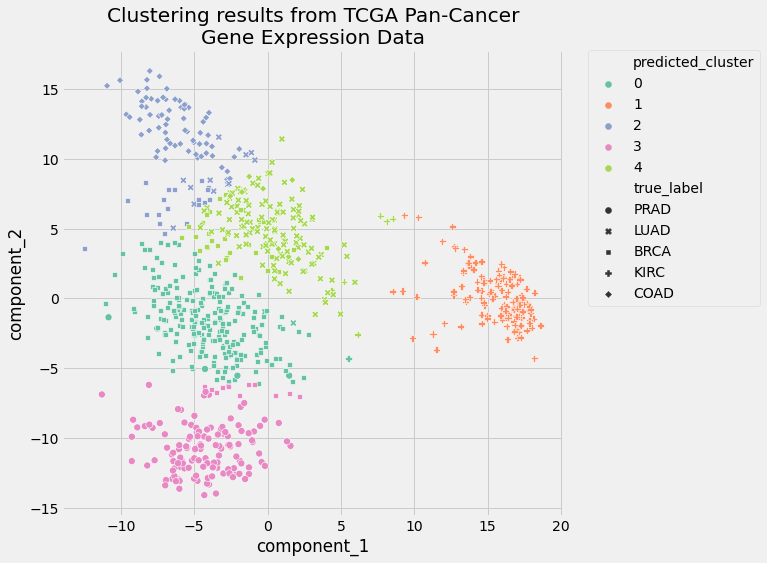

In [7]:
pcadf = pd.DataFrame(
    pipe["preprocesser"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(labels_encoded)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="component_1",
    y="component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()